# Проект: Банки — Анализ оттока клиентов

## Материалы:
* [Презентация] https://disk.yandex.ru/i/E1NL4ZHX2AAMAg
* [Дашборд] https://public.tableau.com/views/_16915858546610/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

**Заказчик** - отдел маркетинга “Метанпромбанка”.<br>
<br>
**Описание проекта:**<br>
    Банковские маркетологи ещё на заре времён выяснили, что удерживать старых клиентов дешевле, чем привлекать новых, задача - помочь им в этом, чтобы «Метанпромбанк» рос, крепчал и развивался. 
    Главной задачей является анализ оттока клиентов. Анализ покажет, какие клиенты уходят из банка, а также поможет составить сегменты клиентов, которые склонны уходить из банка.<br>
    <br>
**Цель проекта:** <br>В банке повысился отток, и с этим нужно что-то делать. Нужно проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка.<br>
<br>
**Ретроспектива:**<br> Ранее было проведено исследование оттока, составлены
дэшборды и выделены сегменты, но клиентская база поменялась, и текущие
решения не работают.<br>
<br>
**Конечный результат:** - Выделены отточные сегменты, даны рекомендации по его
снижению.<br>
<br>


**Этапы проекта:**
1. Загрузка и описание данных. <br>

2. Подготовка данных:<br>
- анализ природы пропусков и их разумная обработка;<br>
- кодирование (для использования в анализе корреляции).<br>

3. EDA:<br>
- анализ распределения признаков, в тч в разрезе оттока;<br>
- анализ портретов клиентов в разрезе оттока;<br>
- корреляционный анализ (в тч интерпретация).<br>

4. Проверка статистических гипотез - минимум две (чем неочевиднее, тем интереснее), не
забываем про обоснование инструмента.<br>

5. Подведение промежуточных итогов - выводы по результатам EDA, корреляционного анализа
и гипотез, выделение признаков, влияющих на оттток.<br>

6. Сегментация (неузкие сегменты; отток лучше, чем средний уровень оттока по банку).<br>

7. Выводы, приоритизация сегментов и формирование рекомендаций (таргетированных) по
работе с ними. <br>

8. Дашборд.

9. Презентация.

### Загрузка и описание данных:

**Загрузим библиотеки:**

In [2]:
!pip install phik
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from scipy import stats as st
import numpy as np
import pandas as pd

**Загрузим файл с данными и выведем первые 5 строк:**

In [3]:
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
df = pd.read_csv(path)
df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


**Данные загружены**

### Подготовка данных:

#### Анализ природы пропусков и их разумная обработка

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


**Датафрейм состоит из 10000 записей. Пропуски имеются в двух полях: "age" и "balance" из 12, следовательно, они не являются полностью случайными, то есть не относятся к категории MCAR. Нужно проверить, относятся ли они к категории MAR или MNAR.**

**Создадим новые признаки пропусков для столбцов balance и age:**

In [5]:
df['age_skip'] = df['age'].isna()
df['balance_skip'] = df['balance'].isna()

**Посчитаем меры центральной тенденции в разрезе пропусков в столбце "balance":**

In [6]:
balance_skip_relations = df.pivot_table(index = 'balance_skip',aggfunc = {'age':'mean', 'EST_SALARY':'mean', 'balance':'median', 'equity':'mean','products':'median', 'gender':pd.Series.mode, 'city':pd.Series.mode, 'score':'mean','credit_card':'median', 'last_activity':'median'}).T.reset_index()
for i in [0,1,2,8]:
    try: balance_skip_relations.loc[i,'Относительная разница'] = (float(balance_skip_relations.loc[i,1])/float(balance_skip_relations.loc[i,0])-1)*100
    except: balance_skip_relations.loc[i,'Относительная разница'] = ''  
balance_skip_relations.columns=['Признак', 'Значение не пропущено', ' Значение пропущено', 'Относительная разница, %']

balance_skip_relations

,Признак,Значение не пропущено,Значение пропущено,"Относительная разница, %"
0,EST_SALARY,124501.872366,226310.208654,81.772534
1,age,42.924366,42.093023,-1.936763
2,balance,524272.2,NaN,NaN
3,city,Ярославль,Ярославль,NaN
4,credit_card,1,1,NaN
5,equity,3.395068,0.05098,NaN
6,gender,Ж,М,NaN
7,last_activity,1,1,NaN
8,products,2,1,-50.000000
9,score,843.73926,865.35207,NaN


**Имеется существенная разница по признакам "EST_SALARY", "equity, "products" и "gender".**

**Посчитаем меры центральной тенденции в разрезе пропусков в столбце "age":**

In [7]:
age_skip_relations = df.pivot_table(index = 'age_skip',aggfunc = {'age':'mean', 'EST_SALARY':'mean', 'balance':'mean', 'equity':'median','products':'median', 'gender':pd.Series.mode, 'city':pd.Series.mode, 'score':'mean','credit_card':'median', 'last_activity':'median'}).T.reset_index()
for i in [0,1,2,8]:
    try: age_skip_relations.loc[i,'Относительная разница'] = (float(age_skip_relations.loc[i,1])/float(age_skip_relations.loc[i,0])-1)*100
    except: age_skip_relations.loc[i,'Относительная разница'] = ''  
age_skip_relations.columns=['Признак', 'Значение не пропущено', ' Значение пропущено', 'Относительная разница, %']

age_skip_relations

,Признак,Значение не пропущено,Значение пропущено,"Относительная разница, %"
0,EST_SALARY,147786.809731,178585.199231,20.839742
1,age,42.734409,NaN,NaN
2,balance,827245.587515,1250033.573,51.107917
3,city,Ярославль,Ярославль,NaN
4,credit_card,1,1,NaN
5,equity,3,0,NaN
6,gender,М,М,NaN
7,last_activity,1,1,NaN
8,products,2,1,-50.000000
9,score,848.682575,855.153846,NaN


**Имеется существенная разница по признакам "EST_SALARY", "balance", "equity, "products" и "gender".**

#### Добавим кодирование (для использования в анализе корреляции) столбцов city и gender, предвариетельно создав копии оригиналов:

In [8]:
df['cities'] = df['city']
df['sex'] = df['gender']
df = pd.get_dummies(data=df, columns=['city', 'gender'])
df

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn,age_skip,balance_skip,cities,sex,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,183012,850.0,25.0,1,59214.82,2,0,1,75719.14,1,False,False,Рыбинск,Ж,0,1,0,1,0
1,146556,861.0,37.0,5,850594.33,3,1,0,86621.77,0,False,False,Рыбинск,Ж,0,1,0,1,0
2,120722,892.0,30.0,0,NaN,1,1,1,107683.34,0,False,True,Рыбинск,Ж,0,1,0,1,0
3,225363,866.0,51.0,5,1524746.26,2,0,1,174423.53,1,False,False,Ярославль,Ж,0,0,1,1,0
4,157978,730.0,34.0,5,174.00,1,1,0,67353.16,1,False,False,Ярославль,М,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,27.0,1,78144.65,1,0,1,18943.64,0,False,False,Рыбинск,М,0,1,0,0,1
9996,139170,894.0,46.0,0,NaN,1,1,0,196898.29,0,False,True,Ярославль,М,0,0,1,0,1
9997,115639,903.0,24.0,0,NaN,2,1,1,108905.09,0,False,True,Ярославль,М,0,0,1,0,1
9998,148700,777.0,68.0,3,865457.97,3,0,1,86874.90,0,False,False,Ярославль,Ж,0,0,1,1,0


**Проверим количество явных дубликатов:**

In [9]:
df.duplicated().sum()

0

**Проверим количество неявных дубликатов:**

In [10]:
df[df['USERID'].duplicated(keep=False)].sort_values(by = 'USERID').head(20)

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn,age_skip,balance_skip,cities,sex,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
1893,116540,883.0,55.0,1,362756.49,3,0,1,175920.48,1,False,False,Рыбинск,Ж,0,1,0,1,0
7694,116540,887.0,38.0,0,NaN,1,0,1,119247.61,0,False,True,Ярославль,Ж,0,0,1,1,0
7542,117943,880.0,40.0,0,NaN,1,1,0,137718.93,0,False,True,Ярославль,Ж,0,0,1,1,0
4866,117943,855.0,32.0,6,1036832.93,4,1,1,107792.71,1,False,False,Рыбинск,Ж,0,1,0,1,0
5896,120258,905.0,30.0,0,NaN,1,1,1,146427.96,0,False,True,Ярославль,М,0,0,1,0,1
5863,120258,908.0,38.0,4,2213581.63,2,0,1,160327.77,1,False,False,Рыбинск,Ж,0,1,0,1,0
1411,123461,829.0,59.0,0,96222.44,2,0,1,102771.55,1,False,False,Ярославль,Ж,0,0,1,1,0
8638,123461,934.0,34.0,0,NaN,2,1,0,291619.27,0,False,True,Рыбинск,М,0,1,0,0,1
8164,124450,859.0,38.0,6,516811.20,1,1,1,95144.63,1,False,False,Ярославль,Ж,0,0,1,1,0
9775,124450,758.0,36.0,0,73574.07,2,0,1,79963.59,0,False,False,Рыбинск,Ж,0,1,0,1,0


**Среди дубликатов по "USERID" есть как очень похожие, так и сильно различающиеся между собой строки, например по возрасту, полу или по городу. У многих пар дубликатов одна из строк имеет признак отскока, но не у всех. Удалять их опасно.**

### EDA:

#### Анализ распределения признаков, в тч в разрезе оттока:

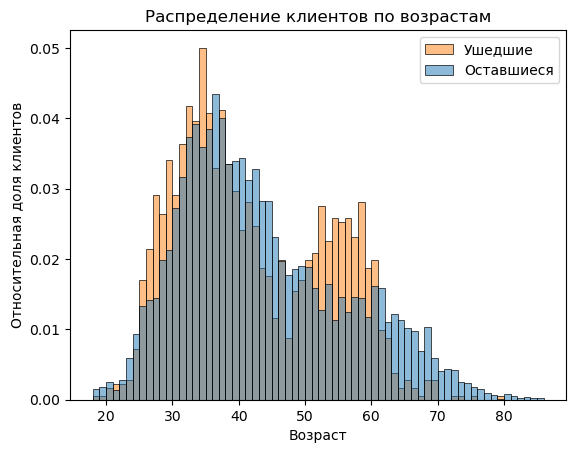

In [11]:
sns.histplot(data=df, x="age", hue="churn", binwidth=1,stat="density", common_norm=False).set(title='Распределение клиентов по возрастам')
plt.ylabel('Относительная доля клиентов')
plt.xlabel('Возраст')
plt.legend(labels=["Ушедшие","Оставшиеся"])
plt.show ()

**Из графика следует, что доля ушедших клиентов в возрасте 25-30 и 50-60 лет выше, чем в других возрастных группах.** 

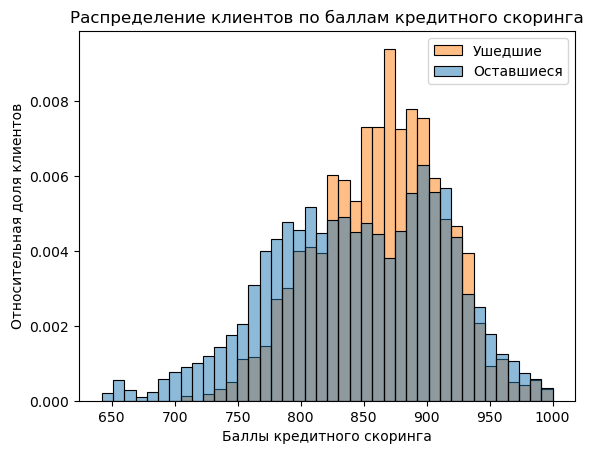

In [12]:
sns.histplot(data=df, x="score", hue="churn", bins = 40,stat="density", common_norm=False).set(title='Распределение клиентов по баллам кредитного скоринга')
plt.ylabel('Относительная доля клиентов')
plt.xlabel('Баллы кредитного скоринга')
plt.legend(labels=["Ушедшие","Оставшиеся"])
plt.show ()

**Из графика следует, что доля ушедших клиентов с кредитным рейтингом от 830 до 910 выше, чем у остальных.** 

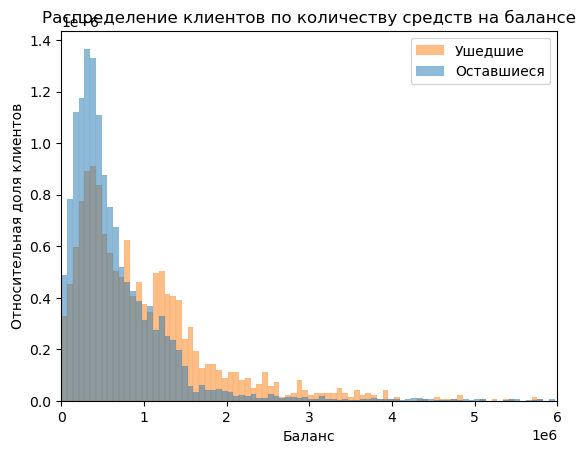

In [14]:
sns.histplot(data=df, x="balance", hue="churn", element="bars", stat="density", common_norm=False).set_title('Распределение клиентов по количеству средств на балансе');
plt.ylabel('Относительная доля клиентов')
plt.xlabel('Баланс')
plt.legend(labels=["Ушедшие","Оставшиеся"])
plt.xlim (-10, 6000000)
plt.show ()

**Из графика следует, что доля ушедших клиентов с балансом от 700 000 до 4 100 000 выше, чем у остальных.** 

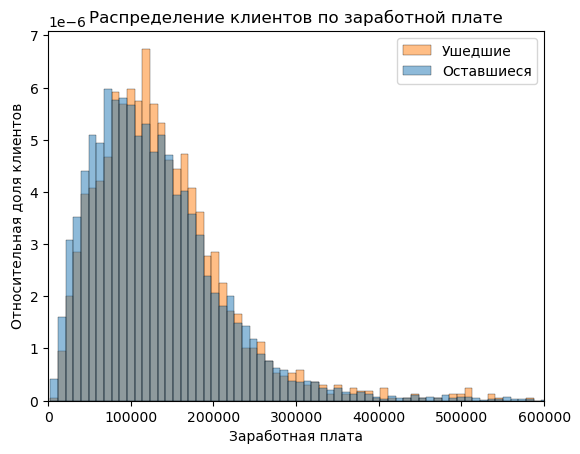

In [16]:
sns.histplot(data=df, x="EST_SALARY", hue="churn", stat="density", common_norm=False, bins = 150).set_title('Распределение клиентов по заработной плате')
plt.ylabel('Относительная доля клиентов')
plt.xlabel('Заработная плата')
plt.legend(labels=["Ушедшие","Оставшиеся"])
plt.xlim (0, 600000)
plt.show ();

**Из графика следует, что доля ушедших выше среди клиентов с заработной платой от 100 до 200 тысяч рублей в месяц.** 

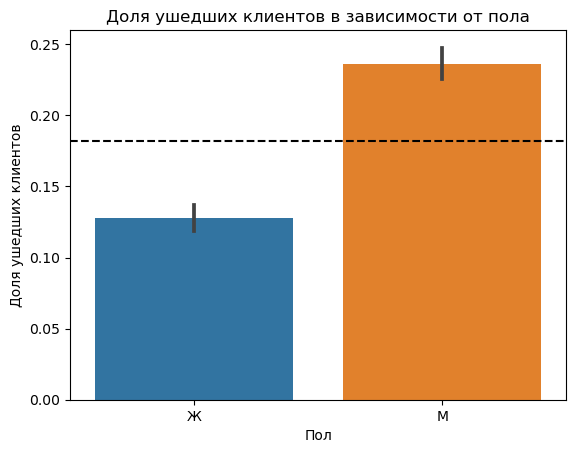

In [17]:
sns.barplot(data = df, x='sex', y = 'churn').set_title('Доля ушедших клиентов в зависимости от пола');
plt.ylabel('Доля ушедших клиентов')
plt.xlabel('Пол')
plt.axhline(y=df['churn'].mean(), color='black', linestyle='--')
plt.show ();

**Из графика следует, что доля ушедших выше среди мужчин.** 

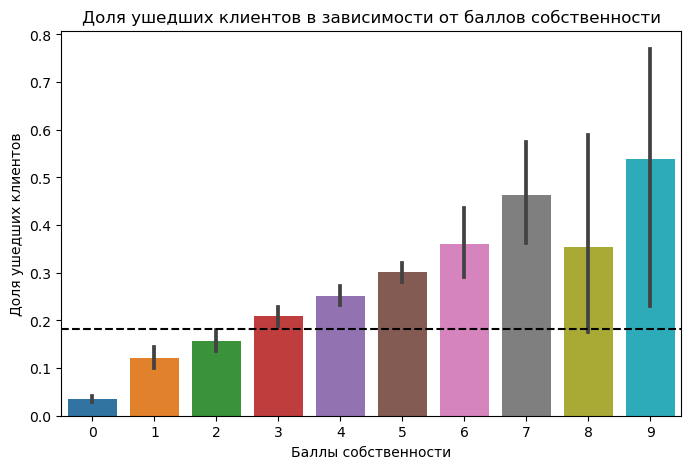

In [20]:
plt.figure(figsize=(8, 5))
sns.barplot(data = df, x='equity', y = 'churn').set_title('Доля ушедших клиентов в зависимости от баллов собственности');
plt.ylabel('Доля ушедших клиентов')
plt.xlabel('Баллы собственности')
plt.axhline(y=df['churn'].mean(), color='black', linestyle='--')
plt.show ();

**Из графика следует, что доля ушедших клиентов с количеством баллов собственности  от 3 до 9 выше, чем у остальных.** 

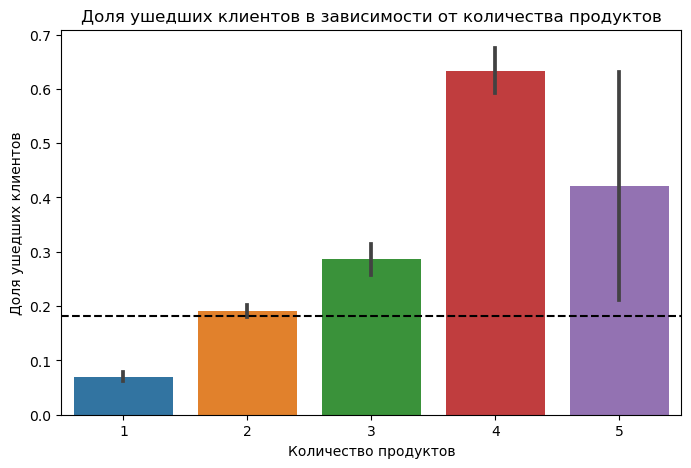

In [21]:
plt.figure(figsize=(8, 5))
sns.barplot(data = df.query('products != 0'), x='products', y = 'churn').set_title('Доля ушедших клиентов в зависимости от количества продуктов');
plt.ylabel('Доля ушедших клиентов')
plt.xlabel('Количество продуктов')
plt.axhline(y=df['churn'].mean(), color='black', linestyle='--')
plt.show ();

**Из графика следует, что доля ушедших клиентов, пользующихся 2 и более продуктами, выше, чем у остальных.** 

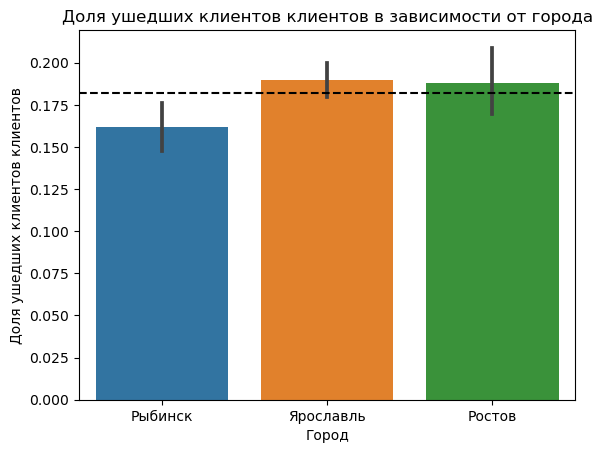

In [22]:
sns.barplot(data = df, x='cities', y = 'churn').set_title('Доля ушедших клиентов клиентов в зависимости от города');
plt.ylabel('Доля ушедших клиентов клиентов')
plt.xlabel('Город')
plt.axhline(y=df['churn'].mean(), color='black', linestyle='--')
plt.show ();

**Из графика следует, что доля ушедших выше среди жителей Ярославля и Ростова.** 

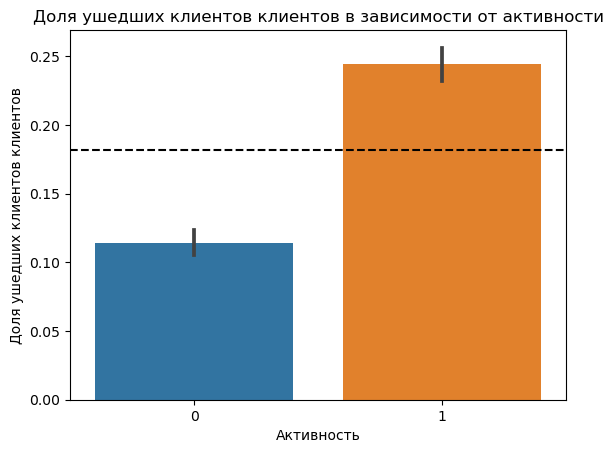

In [23]:
sns.barplot(data = df, x='last_activity', y = 'churn').set_title('Доля ушедших клиентов клиентов в зависимости от активности');
plt.ylabel('Доля ушедших клиентов клиентов')
plt.xlabel('Активность')
plt.axhline(y=df['churn'].mean(), color='black', linestyle='--')
plt.show ();

**Из графика следует, что доля ушедших среди активных клиентов выше, чем среди остальных.** 

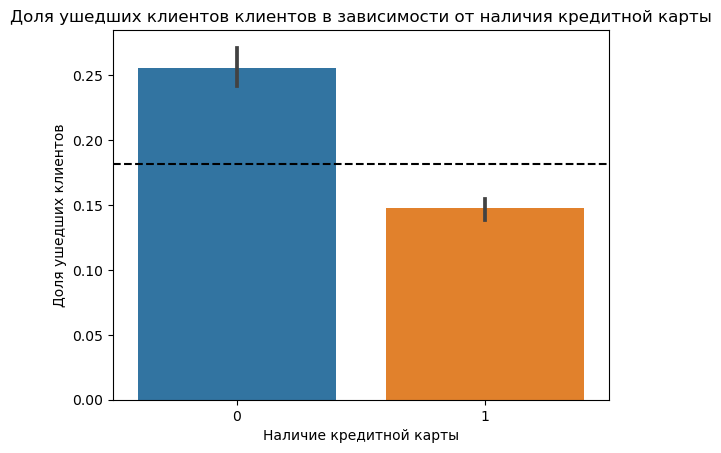

In [24]:
sns.barplot(data = df, x='credit_card', y = 'churn').set_title('Доля ушедших клиентов клиентов в зависимости от наличия кредитной карты');
plt.ylabel('Доля ушедших клиентов')
plt.xlabel('Наличие кредитной карты')
plt.axhline(y=df['churn'].mean(), color='black', linestyle='--')
plt.show ();

**Из графика следует, что доля ушедших клиентов без кредитной карты выше, чем среди остальных.** 

#### Анализ портретов клиентов в разрезе оттока:

In [25]:
portret = df.pivot_table(index = 'churn',aggfunc = {'EST_SALARY':[np.mean, np.median],'age':'mean','balance':[np.mean, np.median], 'equity':'median','products':'median', 'sex':pd.Series.mode, 'cities':pd.Series.mode, 'score':[np.mean, np.median],'credit_card':'median', 'last_activity':'median'}).T.reset_index()

for i in [0,1,2,3,4,10,11]:
    try: portret.loc[i,'Относительная разница'] = (float(portret.loc[i,1])/float(portret.loc[i,0])-1)*100
    except: portret.loc[i,'Относительная разница'] = ''  
portret.columns=['Признак','Агрегатор', 'Не отток', 'Отток', 'Относительная разница, %']

portret


,Признак,Агрегатор,Не отток,Отток,"Относительная разница, %"
0,EST_SALARY,mean,147783.200108,148243.010198,0.311138
1,EST_SALARY,median,118257.715,125390.62,6.031661
2,age,mean,43.020846,41.450247,-3.650785
3,balance,mean,733982.585648,1133993.27145,54.498662
4,balance,median,475382.445,782410.47,64.585478
5,cities,mode,Ярославль,Ярославль,NaN
6,credit_card,median,1.0,1.0,NaN
7,equity,median,3.0,4.0,NaN
8,last_activity,median,0.0,1.0,NaN
9,products,median,2.0,2.0,NaN


**Таблица показывает наличие существенной разницы среднего баланса у отточных и оставшихся клиентов. Из категориальных признаков можно отметить отличие параметров баллов собственности, активности и пола. У параметров EST_SALARY и balance среднее больше медианы. Следовательно, распределение скошено вправо. У параметра score наборот среднее меньше медианы. Следовательно, распределение скошено влево** 

#### Корреляционный анализ (в тч интерпретация):

In [26]:
matrix = df.phik_matrix(interval_cols = ['USERID','score', 'age', 'balance', 'EST_SALARY']).round(2)
for i in matrix.index:
    if matrix['churn'][i] < 0.1:
        matrix.loc[i,'Cheddok'] = "Корреляция отсутствует"
    elif (matrix['churn'][i] >= 0.1) & (matrix['churn'][i] < 0.3):
        matrix.loc[i,'Cheddok'] = "Корреляция слабая"
    elif (matrix['churn'][i] >= 0.3) & (matrix['churn'][i] < 0.5):
        matrix.loc[i,'Cheddok'] = "Корреляция умеренная"
    elif (matrix['churn'][i] >= 0.5) & (matrix['churn'][i] < 0.7):
        matrix.loc[i,'Cheddok'] = "Корреляция заметная"
    elif (matrix['churn'][i] >= 0.7) & (matrix['churn'][i] < 0.9):
        matrix.loc[i,'Cheddok'] = "Корреляция высокая"
    elif (matrix['churn'][i] >= 0.9) & (matrix['churn'][i] <= 0.99):
        matrix.loc[i,'Cheddok'] = "Корреляция весьма высокая"
matrix[['churn', 'Cheddok']].sort_values(by = 'churn', ascending = False)

,churn,Cheddok
churn,1.00,NaN
products,0.44,Корреляция умеренная
balance_skip,0.38,Корреляция умеренная
equity,0.35,Корреляция умеренная
last_activity,0.26,Корреляция слабая
score,0.23,Корреляция слабая
gender_Ж,0.22,Корреляция слабая
sex,0.22,Корреляция слабая
gender_М,0.22,Корреляция слабая
credit_card,0.20,Корреляция слабая


In [27]:
matrix.drop(columns = 'Cheddok', inplace = True)

**Построим тепловую карту по матрице корреляции:**

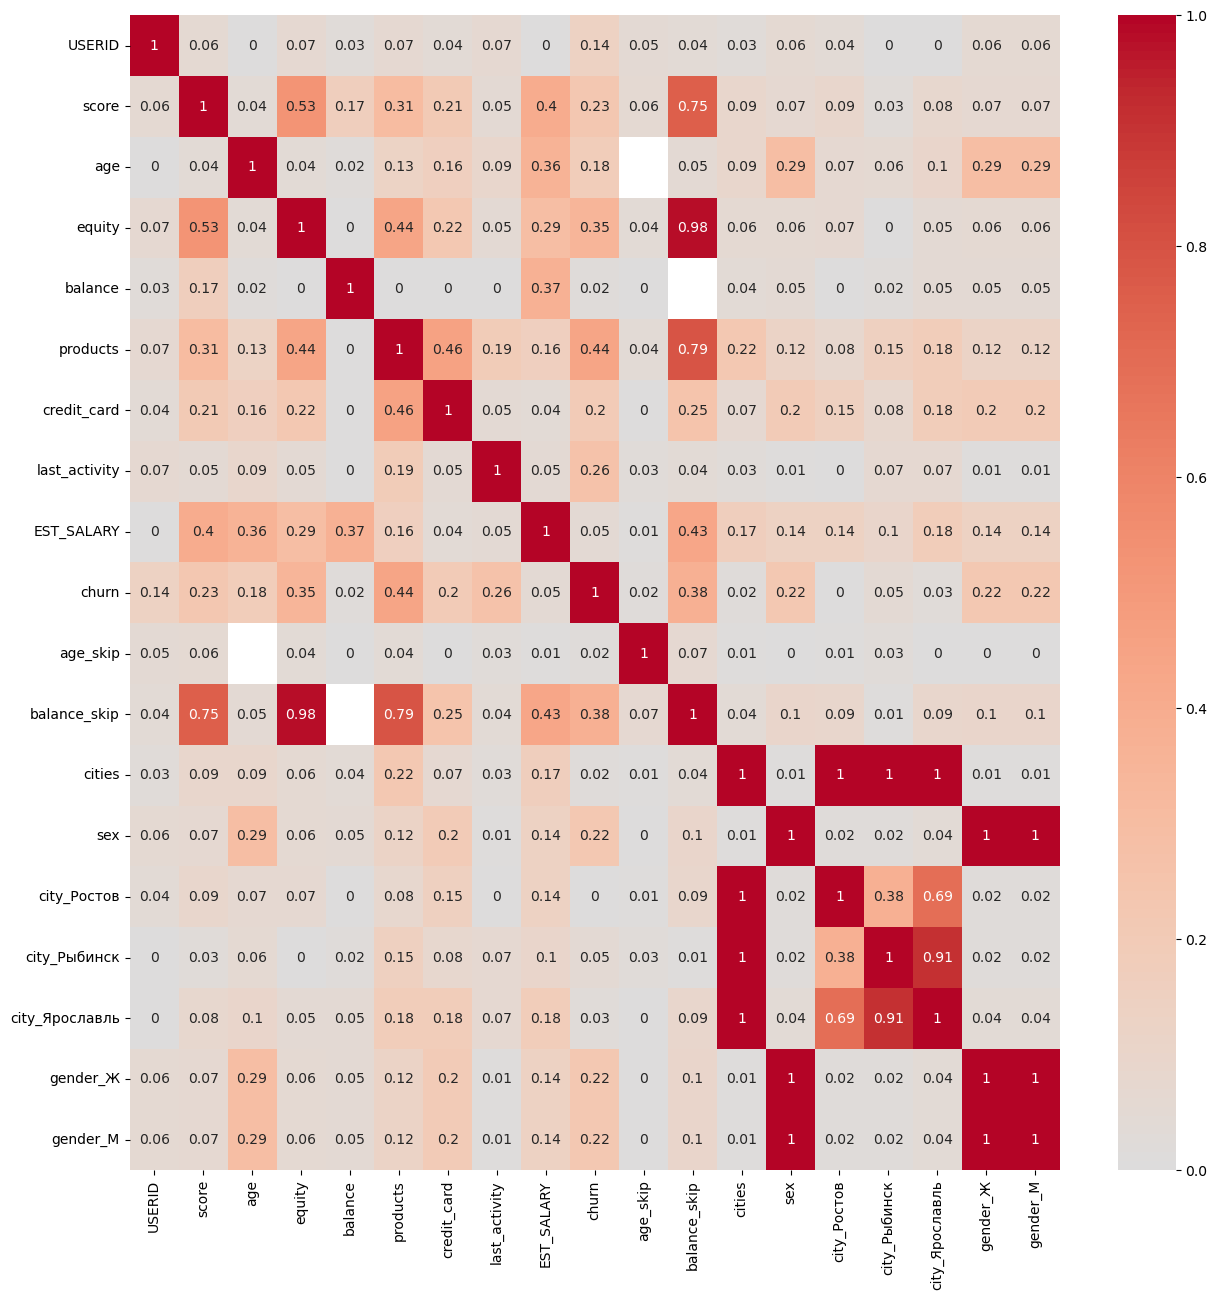

In [28]:
plt.figure(figsize=(15, 15))
sns.heatmap(data = matrix,cmap='coolwarm', center=0, annot=True);

**Наблюдается умеренная корреляция с отскоком количества продуктов и количества баллов собственности и признака пропусков в столбце balance. Также есть слабая корреляция отскока с активностью, баллами кредитного скоринга, полом, наличием кредитной карты и возрастом.** 

### Проверка статистических гипотез:

**Наибольшую корреляцию с отскоком показали параметры products и equity. Поэтому буду проверять гипотезы, касающиеся именно их.**

### Сформулируем гипотезы:

**Гипотеза №1:** <br> 
H0 -  Среднее количество баллов собственности у ушедших клиентов равно среднему количеству баллов собственности у оставшихся;<br>
H1 -  Среднее количество баллов собственности у ушедших клиентов не равно среднему количеству баллов собственности у оставшихся.


**Гипотеза №2:**<br> 
H0 -  Среднее количество используемых продуктов у ушедших клиентов равно среднему количеству используемых продуктов у оставшихся;<br> 
Н1 - Среднее количество используемых продуктов у ушедших клиентов не равно среднему количеству используемых продуктов у оставшихся.

### Проверка гипотез:

**При проверке гипотез буду использовать t-тест для оценки равенства средних двух генеральных совокупностей, так как выполняются 2 условия:** 
   1. Генеральные совокупности не зависят друг от друга (это не одна и та же совокупность до и после какого-то изменения);
   2.  Выборочные средние  нормально распределены. Благодаря ЦПТ, если размер выборки составляет хотя бы несколько десятков значений, выборочные средние, которые можно получить из одной и той же генеральной совокупности, будут распределены нормально вокруг истинного среднего этой совокупности. Это утверждение верно, даже если сама генеральная совокупность не распределена нормально.<br>
   <br>
Поскольку выборки имеют разный размер, возможна и разная дисперсия, поэтому будем использовать equal_var= False 

**Гипотеза № 1**

In [29]:
df.query ('churn == 1')['equity'].count() # проверяем размер меньшей совокупности

1820

In [30]:
churn_equity = df.query ('churn == 1')['equity']

not_churn_equity = df.query ('churn == 0')['equity'] 

alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(churn_equity, not_churn_equity, equal_var= False) 

print('p-значение:', results.pvalue) 

if results.pvalue < 0.05: 
    print("Отвергаем нулевую гипотезу: cреднее количество баллов собственности у ушедших клиентов статистически значимо отличается от среднего количества баллов собственности у оставшихся.")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.2094403736402587e-197
Отвергаем нулевую гипотезу: cреднее количество баллов собственности у ушедших клиентов статистически значимо отличается от среднего количеству баллов собственности у оставшихся.


**Гипотеза № 2**

In [31]:
df.query ('churn == 1')['products'].count()

1820

In [32]:
churn_products = df.query ('churn == 1')['products']

not_churn_products = df.query ('churn == 0')['products']

alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(churn_products, not_churn_products, equal_var= False) 

print('p-значение:', results.pvalue) 

if results.pvalue < 0.05: 
    print("Отвергаем нулевую гипотезу: среднее количество используемых продуктов у ушедших клиентов статистически значимо отличается от среднего количества используемых продуктов у оставшихся.")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.9356112628058777e-138
Отвергаем нулевую гипотезу: среднее количество используемых продуктов у ушедших клиентов статистически значимо отличается от среднего количества используемых продуктов у оставшихся.


**Мы убедились, что группа ушедших пациентов статистически значимо отличается от группы оставшихся, как минимум, по двум критериям: среднему количеству баллов собственности и среднему количеству используемых продуктов.**

### Подведение промежуточных итогов - выводы по результатам EDA, корреляционного анализа и гипотез, выделение признаков, влияющих на оттток:

**В результате проведенного анализа можно выделить следующий признаки, по которым ушедшие пациенты отличаются от оставшихся:**
1. Среднее количество баллов собственности от 3 до 7;
2. 2 и более используемых продукта;
3. Возраст 25-30 и 50-60 лет;
4. Кредитный рейтинг от 830 до 910;
5. Баланс от 700 000 до 4 100 000;
6. Отсутствие кредитной карты;
7. Активность;
8. Заработная плата от 100 до 200 тысяч рублей в месяц;
9. Город Ярославль;
10. Мужской пол.


### Сегментация (неузкие сегменты; отток лучше, чем средний уровень оттока по банку):

**По всем указанным выше критериям отток выше, чем не отток, это следует из графиков. Сочетаний этих критериев можно придумать достаточно много, но по условию задачи нужно выбрать штуки 3, поэтому составляю сочетание из 2-4 критериев наугад. При этом замечу, что большую часть отточных клиентов мы не охватим.**

**Сегмент №1:**<br>
Среднее количество баллов собственности от 3 до 7;<br>
2 и более используемых продукта;<br>
Возраст 25-30 и 50-60 лет.

**Сегмент №2:**<br>
Кредитный рейтинг от 830 до 910;<br>
Баланс от 700 000 до 4 100 000;<br>
Отсутствие кредитной карты;

**Сегмент №3:**<br>
Активность;<br>
Заработная платой от 100 до 200 тысяч рублей в месяц;<br>
Город Ярославль;<br>
Мужской пол.    

**Создадим таблицу, в которую сведём результаты оценки сегментов и данные по всему банку:**

In [33]:
segments = pd.DataFrame()

In [34]:
segments.loc['segment_1','quantity_of_clients'] = df.query('equity >= 3 & equity <= 7 & products>= 2 & ((age >= 25 & age<=30) or (age >= 50 & age<=60))' )['USERID'].count()
segments.loc['segment_1','quantity_of_churn_clients'] = df.query('equity >= 3 & equity <= 7 & products >= 2 & ((age >= 25 & age<=30) or (age >= 50 & age<=60)) & churn == 1' )['USERID'].count()
segments.loc['segment_1','percentages'] = (segments.loc['segment_1','quantity_of_churn_clients']/segments.loc['segment_1','quantity_of_clients']*100).round()

segments.loc['segment_2','quantity_of_clients'] = df.query('score >= 830 & score<=910 & balance >= 700000 & balance<=4100000 & credit_card ==0' )['USERID'].count()
segments.loc['segment_2','quantity_of_churn_clients'] = df.query('score >= 830 & score<=910 & balance >= 700000 & balance<=4100000 & credit_card ==0 & churn == 1' )['USERID'].count()
segments.loc['segment_2','percentages'] = (segments.loc['segment_2','quantity_of_churn_clients']/segments.loc['segment_2','quantity_of_clients']*100).round()

segments.loc['segment_3','quantity_of_clients'] = df.query('last_activity ==1 & EST_SALARY >=100000 & EST_SALARY<=200000 & city_Ярославль == 1 & gender_М == 1' )['USERID'].count()
segments.loc['segment_3','quantity_of_churn_clients'] = df.query('last_activity ==1 & EST_SALARY >=100000 & EST_SALARY<=200000 & city_Ярославль == 1 & gender_М == 1 & churn == 1' )['USERID'].count()
segments.loc['segment_3','percentages'] = (segments.loc['segment_3','quantity_of_churn_clients']/segments.loc['segment_3','quantity_of_clients']*100).round()

segments.loc['whole_bank','quantity_of_clients'] = df['USERID'].count()
segments.loc['whole_bank','quantity_of_churn_clients'] = df.query('churn == 1' )['USERID'].count()
segments.loc['whole_bank','percentages'] = (segments.loc['whole_bank','quantity_of_churn_clients']/segments.loc['whole_bank','quantity_of_clients']*100).round()

segments

,quantity_of_clients,quantity_of_churn_clients,percentages
segment_1,1420.0,540.0,38.0
segment_2,664.0,326.0,49.0
segment_3,650.0,204.0,31.0
whole_bank,10000.0,1820.0,18.0


### Выводы, приоритизация сегментов и формирование рекомендаций (таргетированных) по работе с ними:

**У каждого сегмента есть 2 параметра: количество отточных клиентов и доля отточных клиентов. Для приоритизиции, то есть для выяснения, с какого из сегментов нужно начинать,я бы использовал второй параметр, ведь чем выше доля, тем эффективнее можно работать с этой группой,и с неё имеет смысл начинать.** 

**Отсортируем таблицу с сегментами по убыванию доли отточных клиентов:**

In [35]:
segments.sort_values(by = 'percentages', ascending = False)

,quantity_of_clients,quantity_of_churn_clients,percentages
segment_2,664.0,326.0,49.0
segment_1,1420.0,540.0,38.0
segment_3,650.0,204.0,31.0
whole_bank,10000.0,1820.0,18.0


**Выводы:** 
   1. В результате исследования было выделено 3 сегмента, в которых отток превышает средний отток по всей выборке. 
   2. Результаты были сведены в таблицу и отсортированы по убыванию доли отточных клиентов, которая была взята в качестве критерия приоритизации. 

**Рекомендации:**

1. Рекомендую обратить внимание на пользователей с кредитным рейтингом от 830 до 910, балансом от 700 000 до 4 100 000 и без кредитной карты. Возможно, стоит предложить более выгодные условия по кредитным картам для клиентов с указанным рейтингом и балансом. Также рекомендовал бы оценить, насколько выгодно хранить суммы от 700 000 до 4 100 000 в указанном банке по сравнению с конкурентами. Возможно, стоит предложить более интересные условия по вкладам.  
2. Рекомендую обратить внимание на пользователей с количеством баллов собственности от 3 до 7, двумя и более используемыми продуктами и возрастом 25-30 и 50-60 лет. Это самые обеспеченные и активные пользователи (в плане количества продуктов), но при этом они отточные. Возможно, дело в возрасте. Я бы рекомендовал собрать обратную связь и уточнить запросы пользователей именно этих двух возрастных диапазонов. Могу предположить, что клиентов 25-30 лет интересуют условия по ипотеке, а 50-60 лет - проценты по вкладам.
3. Рекомендую обратить внимание на активных пользователей с заработная платой от 100 до 200 тысяч рублей в месяц из города Ярославля, мужского пола. Это пользователи с зарплатой выше среднего по выборке. Рекомендую обратить внимание на проценты на остаток для указанного сегмента клиентов. Неплохо было бы проверить, насколько удобно хранить, переводить или снимать эти суммы, нет ли каких-либо ограничений. Например, нет ли потолка по вкладам, после которого падает процент. Нет ли ограничений по сумме превода или снятию наличных в месяц. Хорошо бы проверить, какие условия предлагают для указанного сегмента клиентов другие банки. Возможно, клиенты, будучи активными, быстро реагируют на появление более выгодных предложений.

### Дашборд:

https://public.tableau.com/views/_16915858546610/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

### Презентация:

https://disk.yandex.ru/i/E1NL4ZHX2AAMAg